# 疝气病症预测病马死亡率

本次实验使用Logistic回归、LDA与决策树分类器来分别预测患有疝病的马的存活问题，数据集中包含了368个样本和28个特征。数据集中包含了医院检测马疝病的一些指标，有的指标比较主观，有的指标难以测量，例如马的疼痛级别。另外需要说明的是，除了部分指标主观和难以测量外，该数据还存在一个问题，数据集中有30%的值是缺失的。首先在使用三个分类器预测病马的生死之前，需要处理数据集中的数据缺失问题。

## 任务1：数据预处理

* 导入相关包，读取列信息；
* 读入训练集，划分 x_data 与 y_data；
* 删除缺失较多的列，删除标签缺失的样本；
* 离散特征使用one-hot编码，用众数填充缺失值；
* 连续特征使用均值填充缺失值，并对所有连续特征进行minmax 归一化；
* 衡量所有特征之间的相关系数，进行PCA降维后得到x，再观察相关系数变化；
* 加载测试集，划分x_data_test与y_test，再进行上述数据预处理过程。

In [1]:
# 导入包
import pandas as pd
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 取得列信息
with open("resources/horse-colic.names", 'r', encoding='utf-8') as f:
    data_names = f.read()
data_columns = re.findall(r'(?<=[0-9]:).*', data_names)
data_columns = [col.strip() for col in data_columns[:-3]]
print(data_columns)

# one-hot编码列
col_oneHot = ['surgery?', 'Age']

['surgery?', 'Age', 'Hospital Number', 'rectal temperature', 'pulse', 'respiratory rate', 'temperature of extremities', 'peripheral pulse', 'mucous membranes', 'capillary refill time', "pain - a subjective judgement of the horse's pain level", 'peristalsis', 'abdominal distension', 'nasogastric tube', 'nasogastric reflux', 'nasogastric reflux PH', 'rectal examination - feces', 'abdomen', 'packed cell volume', 'total protein', 'abdominocentesis appearance', 'abdomcentesis total protein', 'outcome']


In [2]:
def load_data(data_path):
    horse_data = pd.read_csv(data_path, header=None, sep=r"\s+")
    horse_data = horse_data.loc[:, :22]  # 只取到死亡情况
    horse_data.columns = data_columns  # 修改列名
    horse_data = horse_data.replace("?", float('Nan')) #把问号替换为Nan

    return horse_data

def del_invalid(horse_data, NAN_THRES=0.5):
    col_del = ["Hospital Number"]  # 医院编号与存活率关系不大，选择删除
    # 去除缺失值占比较大的特征
    for col in horse_data.columns:
        if horse_data[col].isna().sum() > len(horse_data) * NAN_THRES and col not in col_del:
            col_del.append(col)
    
    return col_del

def preprocess(horse_data):
    # 调用drop函数，去除horse_data的outcome列
    # x_data = _____________
    x_data = horse_data.drop(columns=['outcome'])
    y_data = horse_data[['outcome']]

    # outcome列修改，2（死亡）、3（被安乐死）均表示死亡，都以2表示；1表示存活
    y_data.loc[y_data['outcome'] == '3', 'outcome'] = '2'
    y_data['outcome'] = pd.to_numeric(y_data['outcome'], errors='coerce').astype('int32')

    # 分离离散列和连续列，分别处理
    x_discrete = x_data[list(set(col_oneHot))]
    x_continue = x_data.drop(columns=x_discrete.columns)

    # 离散特征one-hot编码
    for col in x_discrete.columns:
            column_onehot = pd.get_dummies(x_discrete[col], prefix=col)
            x_discrete = x_discrete.drop(columns=col)
            x_discrete = pd.concat([x_discrete, column_onehot], axis=1)

    # 离散特征用众数填补缺失值
    x_discrete = x_discrete.astype({
        col: 'int32' 
        if x_discrete[col].dtype == 'bool' 
        else x_discrete[col].dtype for col in x_discrete.columns
    })
    imp = SimpleImputer(strategy='most_frequent')
    x_discrete = pd.DataFrame(imp.fit_transform(x_discrete), columns=x_discrete.columns, index=None)
    for col in x_discrete.columns:
        x_discrete[col] = pd.to_numeric(x_discrete[col]).astype('int32')

    # 连续特征用均值填充缺失值
    for col in x_continue.columns:
        x_continue[col] = pd.to_numeric(x_continue[col], errors='coerce').astype("float64")
        # 使用x_continue[col]列的均值填充值为na的特征值
        # x_continue[col] = ________________________
        x_continue[col] = x_continue[col].fillna(x_continue[col].mean())
   
    # 对连续特征使用 minmax 归一化
    # x_continue = ________________________
    x_continue = (x_continue - x_continue.min()) / (x_continue.max() - x_continue.min())

    x_data = pd.concat([x_discrete, x_continue], axis=1)

    x_data = x_data.sort_index(axis=1)  # 对列名排序，保证验证集和训练集特征一一对应

    return x_data, y_data

In [3]:
# 加载训练集
horse_data = load_data("resources/horse-colic.data")
# 删除缺失较多的列
col_del = del_invalid(horse_data)
horse_data = horse_data.drop(columns=col_del)
# 删除标签缺失的样本（存在na的样本）
horse_data = horse_data.dropna(subset=['outcome']).reset_index(drop=True) 
x_data, y_data = preprocess(horse_data)

x_data.info()
col_del

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 20 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Age_1                                                    299 non-null    int32  
 1   Age_9                                                    299 non-null    int32  
 2   abdomen                                                  299 non-null    float64
 3   abdominal distension                                     299 non-null    float64
 4   capillary refill time                                    299 non-null    float64
 5   mucous membranes                                         299 non-null    float64
 6   nasogastric reflux                                       299 non-null    float64
 7   nasogastric tube                                         299 non-null    float64
 8   packed cell volume            

['Hospital Number',
 'nasogastric reflux PH',
 'abdominocentesis appearance',
 'abdomcentesis total protein']

<Axes: >

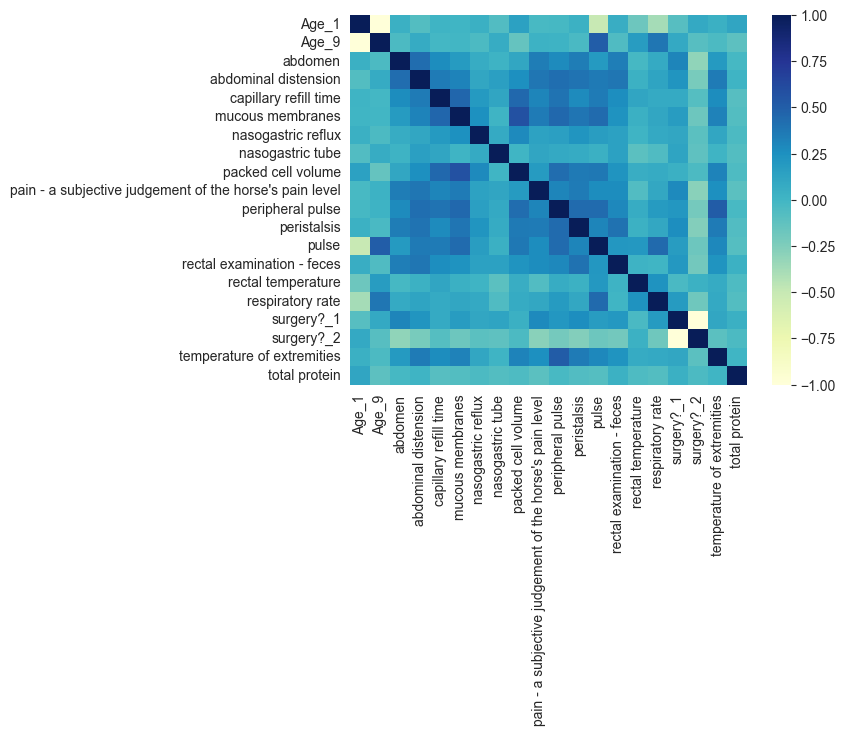

In [4]:
# 衡量特征之间相关系数
df_corr = x_data.corr()
sns.heatmap(df_corr, cmap="YlGnBu")

(299, 12)


<Axes: >

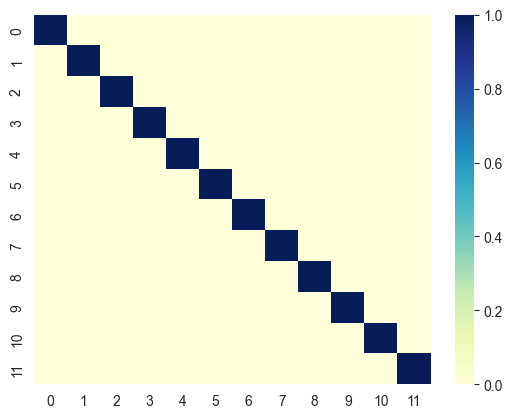

In [5]:
# PCA主成分分析，特征降维
# 调用PCA函数对x_data进行降维，生成12维特征的x
# pca = ___________
# x = pca.___________
pca = PCA(n_components=12)
x = pca.fit_transform(x_data)
print(x.shape)

# 相关系数
df_corr = pd.DataFrame(x, index=None).corr()
sns.heatmap(df_corr, cmap="YlGnBu")

In [6]:
# 测试集处理
data_test = load_data("resources/horse-colic.test")
# 删除缺失较多的列
data_test = data_test.drop(columns=col_del)
# 删除标签缺失的样本
data_test = data_test.dropna(subset=['outcome']).reset_index(drop=True)
x_data_test, y_test = preprocess(data_test)
# 将x_data_test进行PCA特征转换，生成x_test
# x_test = pca.___________
x_test = pca.transform(x_data_test)
print(x_test.shape)

(67, 12)


## 任务2：模型训练与评估

* 导入相关包；
* 调用GridSearchCV函数，使用网格搜索法寻找最优参数penalty与C；
* 使用最优参数的逻辑回归模型进行训练，并对验证集进行预测与评估；
* 自定义逻辑回归函数MyLogisticRegression()，进行模型训练与预测，与上述结果比较；
* 调用sklearn中的LDA函数LinearDiscriminantAnalysis()，进行模型训练与预测，与上述结果比较；
* 调用sklearn中的决策树分类器函数DecisionTreeClassifier()，进行模型训练与测试，与上述结果比较。

In [7]:
# 导入包
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import numpy as np

### 1、调用sklearn中的LogisticRegression函数实现逻辑回归分类

In [8]:
# 网格搜索
params_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# grid = GridSearchCV(___________, param_grid=params_grid, cv=3, verbose=1)
grid = GridSearchCV(LogisticRegression(), param_grid=params_grid, cv=3, verbose=1)
# 对训练样本x与y进行模型超参数的网格搜索
# grid.___________
grid.fit(x, y_data)
lgr_clf = grid.best_estimator_

# 逻辑回归模型训练
# ___________
lgr_clf.fit(x, y_data)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


LogisticRegression(C=1)

In [9]:
# 逻辑回归模型预测
print(lgr_clf.score(x_test, y_test))
y_pred_lgr = lgr_clf.predict(x_test)
print(classification_report(y_pred_lgr, y_test))

0.7611940298507462
              precision    recall  f1-score   support

           1       0.81      0.84      0.83        45
           2       0.65      0.59      0.62        22

    accuracy                           0.76        67
   macro avg       0.73      0.72      0.72        67
weighted avg       0.76      0.76      0.76        67


### 2、自定义逻辑回归函数MyLogisticRegression()，进行模型训练与预测，与上述结果比较。

In [10]:
# 请在下方作答
# 自定义逻辑回归函数
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np

class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty='l2', C=1.0):
        self.penalty = penalty
        self.C = C

    def fit(self, X, y):
        # self.model = LogisticRegression(penalty=self.penalty, C=self.C)
        # self.model.fit(X, y)
        # return self
        # 自定义训练过程，不使用sklearn的LogisticRegression
        X = np.array(X)
        y = np.array(y)
        m, n = X.shape
        self.w = np.zeros((n, 1))
        self.b = 0
        lr = 0.01
        epochs = 1000
        for i in range(epochs):
            z = np.dot(X, self.w) + self.b
            A = 1 / (1 + np.exp(-z))
            dz = A - y
            dw = 1 / m * np.dot(X.T, dz)
            db = 1 / m * np.sum(dz)
            self.w -= lr * dw
            self.b -= lr * db
        return self

    def predict(self, X):
        # return self.model.predict(X)
        # 自定义预测过程，不使用sklearn的LogisticRegression
        X = np.array(X)
        z = np.dot(X, self.w) + self.b
        A = 1 / (1 + np.exp(-z))
        return np.where(A > 0.5, 1, 0)


# 网格搜索
params_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':  [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# grid = GridSearchCV(___________, param_grid=params_grid, cv=3, verbose=1)
grid = GridSearchCV(MyLogisticRegression(), param_grid=params_grid, cv=3, verbose=1)
# 对训练样本x与y进行模型超参数的网格搜索
# grid.___________
grid.fit(x, y_data)
lgr_clf = grid.best_estimator_

# 逻辑回归模型训练
# ___________
lgr_clf.fit(x, y_data)

# 逻辑回归模型预测
print(lgr_clf.score(x_test, y_test))
y_pred_lgr = lgr_clf.predict(x_test)
print(classification_report(y_pred_lgr, y_test))

Fitting 3 folds for each of 21 candidates, totalling 63 fits
0.7014925373134329
              precision    recall  f1-score   support

           1       1.00      0.70      0.82        67
           2       0.00      0.00      0.00         0

    accuracy                           0.70        67
   macro avg       0.50      0.35      0.41        67
weighted avg       1.00      0.70      0.82        67


### 3、调用sklearn中的LDA函数LinearDiscriminantAnalysis()，进行模型训练与预测，与上述结果比较。

In [11]:
# LDA线性判别分析
# 使用未进行PCA降维的20维特征x_data，进行模型训练
# lda_clf = ___________
# lda_clf.___________
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(x_data, y_data)

# 模型测试
print(lda_clf.score(x_data_test, y_test))
y_pred_lda = lda_clf.predict(x_data_test)
print(classification_report(y_pred_lda, y_test))

0.7761194029850746
              precision    recall  f1-score   support

           1       0.83      0.85      0.84        46
           2       0.65      0.62      0.63        21

    accuracy                           0.78        67
   macro avg       0.74      0.73      0.74        67
weighted avg       0.77      0.78      0.77        67


### 4、调用sklearn中的决策树分类器函数DecisionTreeClassifier()，进行模型训练与测试，与上述结果比较。
首先分别使用经过PCA降维与未经过PCA降维的特征进行模型训练，比较结果；然后思考并尝试能够提高分类精度的策略。

In [12]:
# 决策树分类
# 使用未进行PCA降维的20维特征x_data, x_data_test，进行模型训练
# dtc_clf = ___________
# dtc_clf.___________
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(x_data, y_data)

# 模型测试
print(dtc_clf.score(x_data_test, y_test))
y_pred_dtc = dtc_clf.predict(x_data_test)
print(classification_report(y_pred_dtc, y_test))

# 使用进行PCA降维的12维特征x, x_test，进行模型训练
# dtc_clf = ___________
# dtc_clf.___________
dtc_clf = DecisionTreeClassifier()
dtc_clf.fit(x, y_data)

# 模型测试
print(dtc_clf.score(x_test, y_test))
y_pred_dtc = dtc_clf.predict(x_test)
print(classification_report(y_pred_dtc, y_test))

# 尝试能够提高分类精度的策略（选做）
# 请在下方作答

# ----------------------------------------------------------------------

# 超参数调整：对训练样本x与y进行模型超参数的网格搜索
params_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params_grid, cv=3, verbose=1)
grid.fit(x_data, y_data)
dtc_clf = grid.best_estimator_
dtc_clf.fit(x_data, y_data)
print(dtc_clf.score(x_data_test, y_test))
y_pred_dtc = dtc_clf.predict(x_data_test)
print(classification_report(y_pred_dtc, y_test))

0.5671641791044776
              precision    recall  f1-score   support

           1       0.53      0.78      0.63        32
           2       0.65      0.37      0.47        35

    accuracy                           0.57        67
   macro avg       0.59      0.58      0.55        67
weighted avg       0.59      0.57      0.55        67

0.7164179104477612
              precision    recall  f1-score   support

           1       0.77      0.82      0.79        44
           2       0.60      0.52      0.56        23

    accuracy                           0.72        67
   macro avg       0.68      0.67      0.67        67
weighted avg       0.71      0.72      0.71        67

Fitting 3 folds for each of 125 candidates, totalling 375 fits
0.5671641791044776
              precision    recall  f1-score   support

           1       0.64      0.71      0.67        42
           2       0.40      0.32      0.36        25

    accuracy                           0.57        67
   macro